In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

fairuzazaria_rtm_stuck_prediction_dataframes_path = kagglehub.dataset_download('fairuzazaria/rtm-stuck-prediction-dataframes')

print('Data source import complete.')


# **DATA TRANSFORMATION**

In [ ]:
step_in   = 60
step_out  = 60
scaling   = False
well_name = "well_b"
scale_type = "no_scale"
use_additionals = True

if scaling:
    scale_type = "minmax"

In [ ]:
#-- initialize variables
line_plot_conf = {
    "grid"     : True,
    "sharex"   : True,
    "figsize"  : (12, 16),
    "subplots" : True,
}

pie_plot_conf = {
    "autopct" : "%1.1f%%",
    "figsize" : (5, 5),
}

# **1. PREPARATION**

In [ ]:
!pip install fastparquet
!pip install pandas==2.2.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.3 MB/s eta 0:00:0000:010:01


## **1.1. IMPORT LIBRARIES**

In [ ]:
import os
import glob
import h5py
import pyarrow
import datetime
import fastparquet

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis, skew, linregress

In [ ]:
from tqdm.notebook import tqdm
from multiprocessing import Lock

tqdm.set_lock(Lock())

## **1.2. PREPARE FUNCTIONS**

In [ ]:
#-- func: get all dataset directories
def get_dataset_directories(pattern: str = 'txt', dataset_type: str = 'old') -> tuple:
    working_dir = glob.glob(os.path.join(os.getcwd(), 'Datasets', '*'), recursive=True)
    dataset_dir = tuple(
        tuple(
            filename for filename in glob.iglob(os.path.join(dir, '**', f'*{pattern}'), recursive=True)
            if not filename.endswith(f'_pre_{dataset_type}.parquet')
        )
        for dir in working_dir
    )

    return (dataset_dir, working_dir)

In [ ]:
#-- func: check missing timestamps in dataset
def get_missing_timestamps(dataframe: pd.DataFrame, date_column: str, freq: str = '10s') -> tuple:
    missing = pd.date_range(
        start = dataframe[date_column].min(),
        end   = dataframe[date_column].max(),
        freq  = freq
    )

    return tuple(missing.difference(dataframe[date_column]))

In [ ]:
#-- func: apply sliding window
def split_sequences(sequences, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in tqdm(range(len(sequences))):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out

    if out_end_ix > len(sequences):
      break

    seq_x, seq_y = sequences[i:end_ix, :-1], sequences[out_end_ix - 1, -1]
    X.append(seq_x)
    y.append(seq_y)

  return np.array(X), np.array(y)

In [ ]:
def vectorized_statistical_features(X):
    mins   = np.min(X, axis=2, keepdims=True)
    maxs   = np.max(X, axis=2, keepdims=True)
    ranges = maxs - mins

    X_2d = X.reshape(-1, X.shape[2])
    mask = ~np.all(X_2d == X_2d[:, [0]], axis=1)

    skew_vals = np.zeros(X_2d.shape[0])
    kurt_vals = np.zeros(X_2d.shape[0])
    skew_vals[mask] = skew(X_2d[mask], axis=1)
    kurt_vals[mask] = kurtosis(X_2d[mask], axis=1)

    diffs = np.diff(X, axis=2)
    stats = np.concatenate([
        mins, maxs,
        np.mean(X, axis=2, keepdims=True),
        np.std(X, axis=2, keepdims=True),
        np.median(X, axis=2, keepdims=True),
        skew_vals.reshape(X.shape[0], X.shape[1], 1),
        kurt_vals.reshape(X.shape[0], X.shape[1], 1),
        np.mean(diffs, axis=2, keepdims=True),
        np.std(diffs, axis=2, keepdims=True),
        np.min(diffs, axis=2, keepdims=True),
        np.max(diffs, axis=2, keepdims=True),
        ranges
    ], axis=2)

    return stats

In [ ]:
#-- func: remove placeholder values
def set_placeholder_value_to_nan(dataframe: pd.DataFrame, features: list, placeholder: str = '-') -> None:
    for feature in tqdm(features):
        dataframe[feature] = dataframe[feature].apply(lambda value: np.nan if value == placeholder else value)

In [ ]:
#-- func: scale every features
def feature_wise_minmax(X):
    num_samples, timesteps, num_features = X.shape
    X_scaled = np.zeros_like(X)

    scalers = []
    for i in range(num_features):
        scaler  = MinMaxScaler()
        feature = X[:, :, i].reshape(-1, 1)
        X_scaled[:, :, i] = scaler.fit_transform(feature).reshape(num_samples, timesteps)

        scalers.append(scaler)

    return X_scaled, scalers

In [ ]:
#-- func: transform every features
def feature_wise_minmax_transform(X, scalers):
    num_samples, timesteps, num_features = X.shape
    X_scaled = np.zeros_like(X)

    for i in range(num_features):
        feature = X[:, :, i].reshape(-1, 1)
        X_scaled[:, :, i] = scalers[i].transform(feature).reshape(num_samples, timesteps)

    return X_scaled

# **2. PREPROCESS DATA**

## **2.1. READ DATASET**

In [ ]:
#-- read dataset
ph = '/kaggle/input/rtm-stuck-prediction-dataframes/well_b.parquet'
df = pq.read_table(ph).to_pandas()

print(f'fetched {well_name} data with shape {df.shape}')

fetched well_b data with shape (545819, 24)


In [ ]:
#-- define unused feature
features = [
    "Date-Time", "LogDepth",
    "BitDepth", "BlockPos",
    "Hkld", "MudFlowIn",
    "ROPi", "RPM",
    "Torque", "SpPress",
    "WOB", "Stuck"
]

df = df[features]

In [ ]:
#-- convert string datetime to datetime
df['Date-Time'] = pd.to_datetime(df['Date-Time'])
df = df.sort_values(by = ['Date-Time'])
df = df.reset_index(drop=True)
df = df.drop_duplicates()

df.head()

,Date-Time,LogDepth,BitDepth,BlockPos,Hkld,MudFlowIn,ROPi,RPM,Torque,SpPress,WOB,Stuck
0,2023-01-27 14:43:10,0,0,0,48,0,0,0,0,0,0,0
1,2023-01-27 14:43:20,0,0,0,48,0,0,0,0,0,0,0
2,2023-01-27 14:43:30,0,0,0,48,0,0,0,0,0,0,0
3,2023-01-27 14:43:40,0,0,0,48,0,0,0,0,0,0,0
4,2023-01-27 14:43:50,0,0,0,48,0,0,0,0,0,0,0


In [ ]:
#-- dataset info
print(f'{well_name} shape      : {df.shape}')
print(f"{well_name} labels     : {list(df['Stuck'].value_counts())}")
print(f'{well_name} missing    : {len(get_missing_timestamps(df, df.columns[0]))}')
print(f'{well_name} duplicates : {df["Date-Time"].duplicated().sum()}')
print(f'{well_name} nan values : \n\n{df.isna().sum()}\n')

well_b shape      : (545818, 12)
well_b labels     : [503807, 42011]
well_b missing    : 1843
well_b duplicates : 0
well_b nan values : 

Date-Time    0
LogDepth     0
BitDepth     0
BlockPos     0
Hkld         0
MudFlowIn    0
ROPi         0
RPM          0
Torque       0
SpPress      0
WOB          0
Stuck        0
dtype: int64



In [ ]:
#-- check placeholder value counts
placeholder = '-'
placeholder_df  = {feature: np.sum(df[feature] == placeholder) for feature in features}
df_placeholder = pd.DataFrame.from_dict([placeholder_df])
df_placeholder.head()

,Date-Time,LogDepth,BitDepth,BlockPos,Hkld,MudFlowIn,ROPi,RPM,Torque,SpPress,WOB,Stuck
0,0,726,726,726,726,726,726,726,726,726,726,0


In [ ]:
#-- replace placeholder data
set_placeholder_value_to_nan(df, features)
df[df.columns[1:-1]] = df[df.columns[1:-1]].astype(float)

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
#-- dataset info
print(f'{well_name} shape      : {df.shape}')
print(f"{well_name} labels     : {list(df['Stuck'].value_counts())}")
print(f'{well_name} missing    : {len(get_missing_timestamps(df, df.columns[0]))}')
print(f'{well_name} duplicates : {df["Date-Time"].duplicated().sum()}')
print(f'{well_name} nan values : \n\n{df.isna().sum()}\n')

well_b shape      : (545818, 12)
well_b labels     : [503807, 42011]
well_b missing    : 1843
well_b duplicates : 0
well_b nan values : 

Date-Time      0
LogDepth     726
BitDepth     726
BlockPos     726
Hkld         726
MudFlowIn    726
ROPi         726
RPM          726
Torque       726
SpPress      726
WOB          726
Stuck          0
dtype: int64



In [ ]:
#-- fill missing timestamp
df_ms = get_missing_timestamps(df, df.columns[0])
df_m = pd.DataFrame({"Date-Time": df_ms})
df   = pd.concat([df, df_m]).drop_duplicates(subset=["Date-Time"]).sort_values("Date-Time")

df[df.columns[1:-1]] = df[df.columns[1:-1]].interpolate()
df['Stuck'] = df['Stuck'].ffill()

In [ ]:
#-- dataset info
print(f'{well_name} shape      : {df.shape}')
print(f"{well_name} labels     : {list(df['Stuck'].value_counts())}")
print(f'{well_name} missing    : {len(get_missing_timestamps(df, df.columns[0]))}')
print(f'{well_name} duplicates : {df["Date-Time"].duplicated().sum()}')
print(f'{well_name} nan values : \n\n{df.isna().sum()}\n')

well_b shape      : (547661, 12)
well_b labels     : [505630, 42031]
well_b missing    : 0
well_b duplicates : 0
well_b nan values : 

Date-Time    0
LogDepth     0
BitDepth     0
BlockPos     0
Hkld         0
MudFlowIn    0
ROPi         0
RPM          0
Torque       0
SpPress      0
WOB          0
Stuck        0
dtype: int64



## **2.4. STANDARDIZE TIMESTAMPS**

In [ ]:
#-- standardize timestamps
df_resampled = df[df.columns[:-1]].set_index("Date-Time").resample("5s").ffill()
df_resampled["Stuck"] = df.set_index("Date-Time")['Stuck'].resample("5s").ffill()
df_resampled = df_resampled.reset_index()

df = df_resampled
del df_resampled

In [ ]:
#-- dataset info
print(f'{well_name} shape      : {df.shape}')
print(f"{well_name} labels     : {list(df['Stuck'].value_counts())}")
print(f'{well_name} missing    : {len(get_missing_timestamps(df, df.columns[0], freq = "5s"))}')
print(f'{well_name} uplicates  : {df["Date-Time"].duplicated().sum()}')
print(f'{well_name} nan values : \n\n{df.isna().sum()}\n')
print(f'{well_name} negatives  : \n\n{(df[df.columns[1:-1]] < 0).sum()}\n')

well_b shape      : (1095321, 12)
well_b labels     : [1011259, 84062]
well_b missing    : 0
well_b uplicates  : 0
well_b nan values : 

Date-Time    0
LogDepth     0
BitDepth     0
BlockPos     0
Hkld         0
MudFlowIn    0
ROPi         0
RPM          0
Torque       0
SpPress      0
WOB          0
Stuck        0
dtype: int64

well_b negatives  : 

LogDepth        0
BitDepth      338
BlockPos     1588
Hkld          942
MudFlowIn       0
ROPi            0
RPM             0
Torque          0
SpPress         2
WOB             0
dtype: int64



## **2.3. DATA ANALYSIS**

In [ ]:
#-- check each max data:
print(f'{well_name} maxs : \n{df[df.columns[1:-1]].max()}\n')
print(f'{well_name} mins : \n{df[df.columns[1:-1]].min()}\n')

well_b maxs : 
LogDepth      1642.0
BitDepth      1642.0
BlockPos        95.0
Hkld          2029.0
MudFlowIn    19925.0
ROPi          2120.0
RPM          12000.0
Torque         401.0
SpPress       5539.0
WOB            161.0
dtype: float64

well_b mins : 
LogDepth       0.0
BitDepth     -30.0
BlockPos     -22.0
Hkld        -587.0
MudFlowIn      0.0
ROPi           0.0
RPM            0.0
Torque         0.0
SpPress       -3.0
WOB            0.0
dtype: float64



In [ ]:
#-- check unusual Hkld values
df[df["Hkld"] > 500]

,Date-Time,LogDepth,BitDepth,BlockPos,Hkld,MudFlowIn,ROPi,RPM,Torque,SpPress,WOB,Stuck
428684,2023-02-21 10:06:50,1149.0,10.0,31.0,857.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
428685,2023-02-21 10:06:55,1149.0,10.0,31.0,857.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
429104,2023-02-21 10:41:50,1149.0,43.0,4.0,504.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
429105,2023-02-21 10:41:55,1149.0,43.0,4.0,504.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
429106,2023-02-21 10:42:00,1149.0,43.0,4.0,2029.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
429107,2023-02-21 10:42:05,1149.0,43.0,4.0,2029.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df.iloc[368375:368385]

,Date-Time,LogDepth,BitDepth,BlockPos,Hkld,MudFlowIn,ROPi,RPM,Torque,SpPress,WOB,Stuck
368375,2023-02-17 22:21:05,1149.0,1144.0,23.0,331.0,50.0,0.0,11.0,0.0,2218.0,0.0,1.0
368376,2023-02-17 22:21:10,1149.0,1144.0,23.0,403.0,50.0,0.0,11.0,0.0,2219.0,0.0,1.0
368377,2023-02-17 22:21:15,1149.0,1144.0,23.0,403.0,50.0,0.0,11.0,0.0,2219.0,0.0,1.0
368378,2023-02-17 22:21:20,1149.0,1144.0,23.0,403.0,50.0,0.0,11.0,0.0,2235.0,0.0,1.0
368379,2023-02-17 22:21:25,1149.0,1144.0,23.0,403.0,50.0,0.0,11.0,0.0,2235.0,0.0,1.0
368380,2023-02-17 22:21:30,1149.0,1144.0,23.0,401.0,50.0,0.0,11.0,0.0,2238.0,0.0,1.0
368381,2023-02-17 22:21:35,1149.0,1144.0,23.0,401.0,50.0,0.0,11.0,0.0,2238.0,0.0,1.0
368382,2023-02-17 22:21:40,1149.0,1144.0,23.0,403.0,50.0,0.0,11.0,0.0,2241.0,0.0,1.0
368383,2023-02-17 22:21:45,1149.0,1144.0,23.0,403.0,50.0,0.0,11.0,0.0,2241.0,0.0,1.0
368384,2023-02-17 22:21:50,1149.0,1144.0,23.0,401.0,50.0,0.0,11.0,0.0,2231.0,0.0,1.0


In [ ]:
#-- check unusual Hkld values
df[df["MudFlowIn"] > 2000]

,Date-Time,LogDepth,BitDepth,BlockPos,Hkld,MudFlowIn,ROPi,RPM,Torque,SpPress,WOB,Stuck
14232,2023-01-28 10:29:10,37.0,0.0,4.0,51.0,2549.0,0.0,0.0,0.0,0.0,0.0,0.0
14233,2023-01-28 10:29:15,37.0,0.0,4.0,51.0,2549.0,0.0,0.0,0.0,0.0,0.0,0.0
35188,2023-01-29 15:35:30,37.0,0.0,5.0,50.0,2097.0,0.0,273.0,0.0,0.0,0.0,0.0
35189,2023-01-29 15:35:35,37.0,0.0,5.0,50.0,2097.0,0.0,273.0,0.0,0.0,0.0,0.0
47628,2023-01-30 08:52:10,115.0,115.0,28.0,91.0,8255.0,12.0,1123.0,6.0,928.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
720175,2023-03-10 06:57:45,1256.0,333.0,14.0,67.0,2549.0,0.0,0.0,0.0,0.0,0.0,0.0
720176,2023-03-10 06:57:50,1256.0,333.0,14.0,67.0,2527.0,0.0,0.0,0.0,0.0,0.0,0.0
720177,2023-03-10 06:57:55,1256.0,333.0,14.0,67.0,2527.0,0.0,0.0,0.0,0.0,0.0,0.0
720178,2023-03-10 06:58:00,1256.0,333.0,14.0,67.0,2527.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.iloc[720175:720185]

,Date-Time,LogDepth,BitDepth,BlockPos,Hkld,MudFlowIn,ROPi,RPM,Torque,SpPress,WOB,Stuck
720175,2023-03-10 06:57:45,1256.0,333.0,14.0,67.0,2549.0,0.0,0.0,0.0,0.0,0.0,0.0
720176,2023-03-10 06:57:50,1256.0,333.0,14.0,67.0,2527.0,0.0,0.0,0.0,0.0,0.0,0.0
720177,2023-03-10 06:57:55,1256.0,333.0,14.0,67.0,2527.0,0.0,0.0,0.0,0.0,0.0,0.0
720178,2023-03-10 06:58:00,1256.0,333.0,14.0,67.0,2527.0,0.0,0.0,0.0,0.0,0.0,0.0
720179,2023-03-10 06:58:05,1256.0,333.0,14.0,67.0,2527.0,0.0,0.0,0.0,0.0,0.0,0.0
720180,2023-03-10 06:58:10,1256.0,333.0,14.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
720181,2023-03-10 06:58:15,1256.0,333.0,14.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
720182,2023-03-10 06:58:20,1256.0,333.0,14.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
720183,2023-03-10 06:58:25,1256.0,333.0,14.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
720184,2023-03-10 06:58:30,1256.0,333.0,14.0,67.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df[df["ROPi"] > 200]

,Date-Time,LogDepth,BitDepth,BlockPos,Hkld,MudFlowIn,ROPi,RPM,Torque,SpPress,WOB,Stuck
76,2023-01-27 14:49:30,2.0,2.0,28.0,48.0,0.0,596.0,0.0,0.0,0.0,0.0,0.0
77,2023-01-27 14:49:35,2.0,2.0,28.0,48.0,0.0,596.0,0.0,0.0,0.0,0.0,0.0
78,2023-01-27 14:49:40,4.0,4.0,26.0,48.0,0.0,836.0,0.0,0.0,0.0,0.0,0.0
79,2023-01-27 14:49:45,4.0,4.0,26.0,48.0,0.0,836.0,0.0,0.0,0.0,0.0,0.0
186,2023-01-27 14:58:40,5.0,5.0,25.0,48.0,0.0,854.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
695863,2023-03-08 21:11:45,1181.0,1180.0,20.0,148.0,806.0,315.0,41.0,14.0,1390.0,10.0,0.0
1087470,2023-03-31 13:05:40,1600.0,1600.0,5.0,146.0,723.0,262.0,69.0,10.0,1254.0,8.0,0.0
1087471,2023-03-31 13:05:45,1600.0,1600.0,5.0,146.0,723.0,262.0,69.0,10.0,1254.0,8.0,0.0
1088396,2023-03-31 14:22:50,1604.0,1604.0,1.0,145.0,723.0,355.0,58.0,10.0,1277.0,9.0,0.0


In [ ]:
df.iloc[190:200]

,Date-Time,LogDepth,BitDepth,BlockPos,Hkld,MudFlowIn,ROPi,RPM,Torque,SpPress,WOB,Stuck
190,2023-01-27 14:59:00,16.0,16.0,14.0,48.0,0.0,2120.0,0.0,0.0,0.0,0.0,0.0
191,2023-01-27 14:59:05,16.0,16.0,14.0,48.0,0.0,2120.0,0.0,0.0,0.0,0.0,0.0
192,2023-01-27 14:59:10,22.0,22.0,8.0,48.0,0.0,2019.0,0.0,0.0,0.0,0.0,0.0
193,2023-01-27 14:59:15,22.0,22.0,8.0,48.0,0.0,2019.0,0.0,0.0,0.0,0.0,0.0
194,2023-01-27 14:59:20,26.0,26.0,4.0,48.0,0.0,354.0,0.0,0.0,0.0,0.0,0.0
195,2023-01-27 14:59:25,26.0,26.0,4.0,48.0,0.0,354.0,0.0,0.0,0.0,0.0,0.0
196,2023-01-27 14:59:30,26.0,26.0,4.0,48.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
197,2023-01-27 14:59:35,26.0,26.0,4.0,48.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
198,2023-01-27 14:59:40,26.0,26.0,4.0,48.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
199,2023-01-27 14:59:45,26.0,26.0,4.0,48.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df[df["RPM"] > 300]

,Date-Time,LogDepth,BitDepth,BlockPos,Hkld,MudFlowIn,ROPi,RPM,Torque,SpPress,WOB,Stuck
47628,2023-01-30 08:52:10,115.0,115.0,28.0,91.0,8255.0,12.0,1123.0,6.0,928.0,2.0,0.0
47629,2023-01-30 08:52:15,115.0,115.0,28.0,91.0,8255.0,12.0,1123.0,6.0,928.0,2.0,0.0
47808,2023-01-30 09:07:10,118.0,118.0,25.0,86.0,8608.0,21.0,1169.0,7.0,964.0,7.0,0.0
47809,2023-01-30 09:07:15,118.0,118.0,25.0,86.0,8608.0,21.0,1169.0,7.0,964.0,7.0,0.0
49184,2023-01-30 11:01:50,136.0,136.0,6.0,85.0,19925.0,9.0,2640.0,8.0,983.0,10.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
971589,2023-03-24 20:08:55,1279.0,0.0,1.0,51.0,0.0,0.0,321.0,0.0,0.0,0.0,0.0
991842,2023-03-26 00:16:40,1279.0,0.0,1.0,48.0,0.0,0.0,448.0,0.0,0.0,0.0,0.0
991843,2023-03-26 00:16:45,1279.0,0.0,1.0,48.0,0.0,0.0,448.0,0.0,0.0,0.0,0.0
1061874,2023-03-30 01:32:40,1537.0,1527.0,11.0,46.0,0.0,0.0,382.0,0.0,0.0,0.0,0.0


In [ ]:
df[df["Torque"] > 50]

,Date-Time,LogDepth,BitDepth,BlockPos,Hkld,MudFlowIn,ROPi,RPM,Torque,SpPress,WOB,Stuck
938942,2023-03-22 22:48:20,1279.0,0.0,7.0,27.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0
938943,2023-03-22 22:48:25,1279.0,0.0,7.0,27.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0
938944,2023-03-22 22:48:30,1279.0,0.0,7.0,27.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0
938945,2023-03-22 22:48:35,1279.0,0.0,7.0,27.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0
938946,2023-03-22 22:48:40,1279.0,0.0,7.0,27.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
939463,2023-03-22 23:31:45,1279.0,0.0,6.0,26.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0
939466,2023-03-22 23:32:00,1279.0,0.0,6.0,37.0,0.0,0.0,0.0,400.0,0.0,0.0,0.0
939467,2023-03-22 23:32:05,1279.0,0.0,6.0,37.0,0.0,0.0,0.0,400.0,0.0,0.0,0.0
939468,2023-03-22 23:32:10,1279.0,0.0,6.0,39.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0


In [ ]:
#-- check error ropi values
df[(df["ROPi"] > 0) & (df["RPM"] == 0) & (df["Torque"] == 0)]

,Date-Time,LogDepth,BitDepth,BlockPos,Hkld,MudFlowIn,ROPi,RPM,Torque,SpPress,WOB,Stuck
74,2023-01-27 14:49:20,1.0,1.0,29.0,48.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
75,2023-01-27 14:49:25,1.0,1.0,29.0,48.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
76,2023-01-27 14:49:30,2.0,2.0,28.0,48.0,0.0,596.0,0.0,0.0,0.0,0.0,0.0
77,2023-01-27 14:49:35,2.0,2.0,28.0,48.0,0.0,596.0,0.0,0.0,0.0,0.0,0.0
78,2023-01-27 14:49:40,4.0,4.0,26.0,48.0,0.0,836.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
732079,2023-03-10 23:29:45,1257.0,1257.0,20.0,120.0,850.0,2.0,0.0,0.0,1354.0,29.0,1.0
732080,2023-03-10 23:29:50,1257.0,1257.0,20.0,113.0,850.0,22.0,0.0,0.0,1350.0,37.0,1.0
732081,2023-03-10 23:29:55,1257.0,1257.0,20.0,113.0,850.0,22.0,0.0,0.0,1350.0,37.0,1.0
732082,2023-03-10 23:30:00,1257.0,1257.0,20.0,100.0,850.0,9.0,0.0,0.0,1351.0,50.0,1.0


## **2.4 HANDLE OUTLIERS**

In [ ]:
#-- replace ROPi outliers
df["ROPi"] = df.apply(lambda row: 0 if (
    row["ROPi"] > 0 and
    row["RPM"] == 0 and
    row["Torque"] == 0
) else row["ROPi"], axis=1)

In [ ]:
#-- replace MudFlowIn outliers
df["MudFlowIn"] = df["MudFlowIn"].apply(lambda value: np.nan if (value > 2000) else value)
df["MudFlowIn"] = df["MudFlowIn"].interpolate().ffill()

In [ ]:
#-- replace RPM outliers
df["RPM"] = df["RPM"].apply(lambda value: np.nan if (value > 300) else value)
df["RPM"] = df["RPM"].interpolate().ffill()

In [ ]:
#-- replace Hkld outliers
df["Hkld"] = df["Hkld"].apply(lambda value: np.nan if (value > 500) else value)
df["Hkld"] = df["Hkld"].interpolate().ffill()

In [ ]:
#-- replace Torque outliers
df["Torque"] = df["Torque"].apply(lambda value: 50 if (value > 50) else value)

In [ ]:
#-- replace negative values with nan
for column in tqdm(df.columns[1:-1]):
    df[column] = df[column].apply(lambda value: np.nan if value < 0 else value)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
#-- check each max data:
print(f'{well_name} maxs : \n{df[df.columns[1:-1]].max()}\n')
print(f'{well_name} mins : \n{df[df.columns[1:-1]].min()}\n')

well_b maxs : 
LogDepth     1642.0
BitDepth     1642.0
BlockPos       95.0
Hkld          416.0
MudFlowIn    1986.0
ROPi          512.0
RPM           289.0
Torque         50.0
SpPress      5539.0
WOB           161.0
dtype: float64

well_b mins : 
LogDepth     0.0
BitDepth     0.0
BlockPos     0.0
Hkld         0.0
MudFlowIn    0.0
ROPi         0.0
RPM          0.0
Torque       0.0
SpPress      0.0
WOB          0.0
dtype: float64



## **2.5 FILL NAN VALUES**

In [ ]:
#-- interpolate nan values
df["Hkld"]     = df["Hkld"].interpolate()
df["SpPress"]  = df["SpPress"].interpolate()
df["BitDepth"] = df["BitDepth"].interpolate()
df["BlockPos"] = df["BlockPos"].interpolate()

#-- clip negatives
df[df.columns[1:-1]] = df[df.columns[1:-1]].clip(lower=0)

In [ ]:
#-- dataset info
print(f'{well_name} shape      : {df.shape}')
print(f"{well_name} labels     : {list(df['Stuck'].value_counts())}")
print(f'{well_name} missing    : {len(get_missing_timestamps(df, df.columns[0], freq = "5s"))}')
print(f'{well_name} uplicates  : {df["Date-Time"].duplicated().sum()}')
print(f'{well_name} nan values : \n\n{df.isna().sum()}\n')
print(f'{well_name} negatives  : \n\n{(df[df.columns[1:-1]] < 0).sum()}\n')

well_b shape      : (1095321, 12)
well_b labels     : [1011259, 84062]
well_b missing    : 0
well_b uplicates  : 0
well_b nan values : 

Date-Time    0
LogDepth     0
BitDepth     0
BlockPos     0
Hkld         0
MudFlowIn    0
ROPi         0
RPM          0
Torque       0
SpPress      0
WOB          0
Stuck        0
dtype: int64

well_b negatives  : 

LogDepth     0
BitDepth     0
BlockPos     0
Hkld         0
MudFlowIn    0
ROPi         0
RPM          0
Torque       0
SpPress      0
WOB          0
dtype: int64



## **2.6. FEATURE EXTRACTION**

In [ ]:
#-- get differences
df["RpmDiff"]      = df["RPM"].diff().fillna(0)
df["HkldDiff"]     = df["Hkld"].diff().fillna(0)
df["TorqueDiff"]   = df["Torque"].diff().fillna(0)
df["BitDepthDiff"] = df["BitDepth"].diff().fillna(0)
df["LogDepthDiff"] = df["LogDepth"].diff().fillna(0)

In [ ]:
df["BitDepthRollMin"] = df["BitDepth"].rolling(180).min().fillna(0)
df["BitDepthRollMax"] = df["BitDepth"].rolling(180).max().fillna(0)

df["BitDepthRollMinDiff"] = df["BitDepthRollMin"].diff().fillna(0)
df["BitDepthRollMaxDiff"] = df["BitDepthRollMax"].diff().fillna(0)

df["HkldRollMin"] = df["Hkld"].rolling(180).min().fillna(0)
df["HkldRollMax"] = df["Hkld"].rolling(180).max().fillna(0)

In [ ]:
#-- check ROPi
miss_rop = len(df[(df["ROPi"] == 0) & (df["RPM"] > 0) & (df["Torque"] > 0) & (df["BitDepthDiff"] > 0) & (df["LogDepthDiff"] > 0)])
print(f"miscalculated ROPi: {miss_rop}")

miscalculated ROPi: 5


In [ ]:
#-- adjust ROPi
df["ROPi"] = df.apply(lambda row: 1e-6 if (
    row["ROPi"] == 0 and
    row["RPM"] > 0 and
    row["Torque"] > 0 and
    row["BitDepthDiff"] > 0 and
    row["LogDepthDiff"] > 0
) else row["ROPi"], axis=1)

In [ ]:
#-- check bit location
df["BitInsideWell"] = df.apply(lambda row: 1 if (row["BitDepth"] != 0) else 0, axis=1)

In [ ]:
#-- check if unstable shell exist
df["ShellOnBitString"] = df.apply(lambda row: 1 if (
    (0 <= row["BitDepthRollMax"] - row["BitDepthRollMin"] <= 1) and
    row["RPM"] > 0 and
    row["Torque"] > 0
) else 0, axis=1)

In [ ]:
#-- check for bit drill
df["HIghForceNoRotation"] = df.apply(lambda row: 1 if (
    row["RPM"] == 0 and
    row["Torque"] > 0
) else 0, axis=1)

In [ ]:
#-- calculate drag
df["Drag"] = df.apply(lambda row: row["HkldDiff"] if (row["BitDepthDiff"] != 0) else 0, axis=1)
df["Drag"] = df.apply(lambda row: 0 if (row["Drag"] < 0) else row["Drag"], axis=1)

In [ ]:
#-- calculate overpull
df["Overpull"] = df.apply(lambda row: row["Hkld"] - row["HkldRollMin"] if (
    row["BitDepthDiff"] == 0 and
    row["Hkld"] > row["HkldRollMin"]
) else 0, axis=1)

In [ ]:
#-- check pump flow rate
df["PumpFlow"] = df.apply(lambda row: 1 if row["MudFlowIn"] != 0 else 0, axis=1)

In [ ]:
#-- check stall
df["Stall"] = df.apply(lambda row: 1 if (
    row["RPM"] == 0 and
    row["RpmDiff"] < 0 and
    row["TorqueDiff"] > 0
) else 0, axis=1)

In [ ]:
#-- check POOH and RIH
df["POOH"] = df.apply(lambda row: 1 if (
    row["BitDepthRollMinDiff"] < 0 and
    row["ROPi"] == 0 and
    row["WOB"] == 0 and
    row["LogDepthDiff"] == 0
) else 0, axis=1)

df["RIH"] = df.apply(lambda row: 1 if (
    row["BitDepthRollMaxDiff"] > 0 and
    row["ROPi"] == 0 and
    row["WOB"] == 0 and
    row["LogDepthDiff"] == 0
) else 0, axis=1)

In [ ]:
#-- check general activities
df["reaming"] = df.apply(lambda row: 1 if (
    row["RPM"] > 0 and
    row["WOB"] == 0 and
    row["ROPi"] == 0 and
    row["Torque"] > 0 and
    row["SpPress"] >= 0 and
    row["MudFlowIn"] > 0
) else 0, axis=1)

df["drilling"] = df.apply(lambda row: 1 if (
    row["WOB"] > 0 and
    row["RPM"] > 0 and
    row["ROPi"] > 0 and
    row["Torque"] >= 0 and
    row["LogDepthDiff"] > 0
) else 0, axis=1)

df["connection"] = df.apply(lambda row: 1 if (
    row["RPM"] == 0 and
    row["WOB"] == 0 and
    row["ROPi"] == 0 and
    row["LogDepthDiff"] == 0
) else 0, axis=1)

df["others"] = df.apply(lambda row: 1 if (
    row["reaming"] == 0 and
    row["drilling"] == 0 and
    row["connection"] == 0
) else 0, axis=1)

In [ ]:
#-- drop unused columns
df_stuck = df["Stuck"]
columns  = [
    "LogDepth",
    "BitDepth",
    "BlockPos",
    "BitDepthDiff",
    "LogDepthDiff",
    "HkldDiff",
    "RpmDiff",
    "TorqueDiff",
    "BitDepthRollMin",
    "BitDepthRollMax",
    "BitDepthRollMinDiff",
    "BitDepthRollMaxDiff",
    "HkldRollMin",
    "HkldRollMax",
    "Stuck"
]

df = df.drop(columns=columns)
df["Stuck"] = df_stuck

In [ ]:
#-- check activity overlapp
print(df.loc[(df["reaming"] == 1) & (df["drilling"] == 1)].shape)
print(df.loc[(df["reaming"] == 1) & (df["connection"] == 1)].shape)
print(df.loc[(df["connection"] == 1) & (df["drilling"] == 1)].shape)
print(df.loc[(df["connection"] == 1) & (df["reaming"] == 1)].shape)
print(df.loc[(df["drilling"] == 1) & (df["reaming"] == 1)].shape)
print(df.loc[(df["drilling"] == 1) & (df["connection"] == 1)].shape)

print(df.loc[(df["reaming"] == 1) & (df["drilling"] == 1) & (df["connection"] == 1)].shape)
print(df.loc[(df["reaming"] == 0) & (df["drilling"] == 0) & (df["connection"] == 0) & (df["others"] == 0)].shape)

(0, 22)
(0, 22)
(0, 22)
(0, 22)
(0, 22)
(0, 22)
(0, 22)
(0, 22)


In [ ]:
#-- dataset info
print(f'{well_name} shape      : {df.shape}')
print(f"{well_name} labels     : {list(df['Stuck'].value_counts())}")
print(f'{well_name} missing    : {len(get_missing_timestamps(df, df.columns[0], freq = "5s"))}')
print(f'{well_name} uplicates  : {df["Date-Time"].duplicated().sum()}')
print(f'{well_name} nan values : \n\n{df.isna().sum()}\n')
print(f'{well_name} negatives  : \n\n{(df[df.columns[1:-1]] < 0).sum()}\n')

well_b shape      : (1095321, 22)
well_b labels     : [1011259, 84062]
well_b missing    : 0
well_b uplicates  : 0
well_b nan values : 

Date-Time              0
Hkld                   0
MudFlowIn              0
ROPi                   0
RPM                    0
Torque                 0
SpPress                0
WOB                    0
BitInsideWell          0
ShellOnBitString       0
HIghForceNoRotation    0
Drag                   0
Overpull               0
PumpFlow               0
Stall                  0
POOH                   0
RIH                    0
reaming                0
drilling               0
connection             0
others                 0
Stuck                  0
dtype: int64

well_b negatives  : 

Hkld                   0
MudFlowIn              0
ROPi                   0
RPM                    0
Torque                 0
SpPress                0
WOB                    0
BitInsideWell          0
ShellOnBitString       0
HIghForceNoRotation    0
Drag                   0
Ov

array([<Axes: xlabel='Date-Time'>, <Axes: xlabel='Date-Time'>,
       <Axes: xlabel='Date-Time'>, <Axes: xlabel='Date-Time'>,
       <Axes: xlabel='Date-Time'>, <Axes: xlabel='Date-Time'>,
       <Axes: xlabel='Date-Time'>, <Axes: xlabel='Date-Time'>,
       <Axes: xlabel='Date-Time'>, <Axes: xlabel='Date-Time'>,
       <Axes: xlabel='Date-Time'>, <Axes: xlabel='Date-Time'>,
       <Axes: xlabel='Date-Time'>, <Axes: xlabel='Date-Time'>,
       <Axes: xlabel='Date-Time'>, <Axes: xlabel='Date-Time'>,
       <Axes: xlabel='Date-Time'>, <Axes: xlabel='Date-Time'>,
       <Axes: xlabel='Date-Time'>, <Axes: xlabel='Date-Time'>,
       <Axes: xlabel='Date-Time'>], dtype=object)

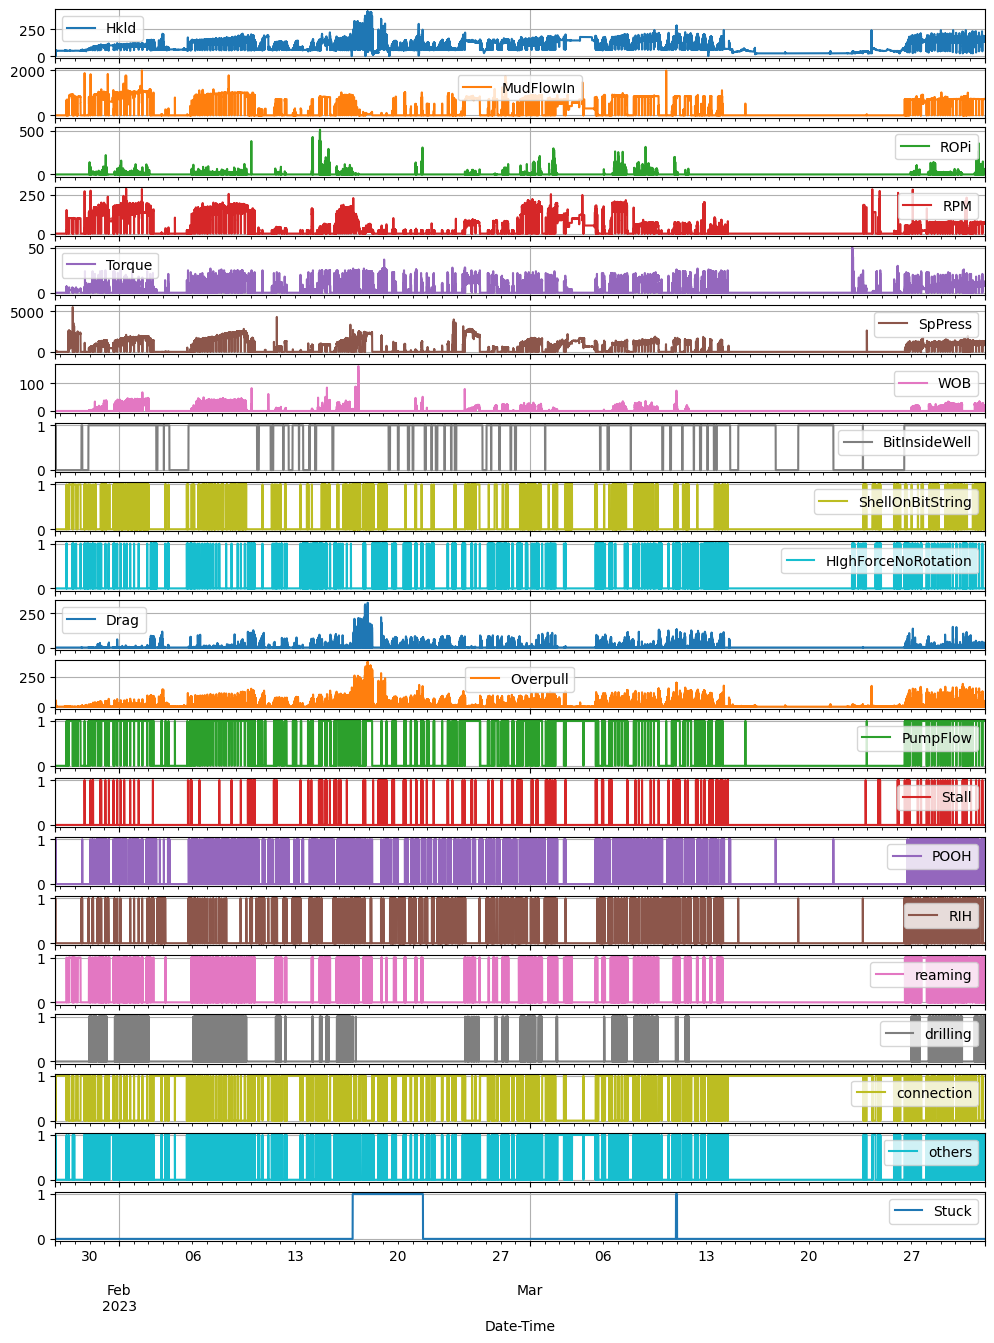

In [ ]:
df.set_index("Date-Time").plot(**line_plot_conf)

## **2.7. PROCESS DISTRUPTED TIMESERIES**

In [ ]:
#-- distrupted timesteps
distrupted = [
    (datetime.datetime(2023, 2, 17, 11, 18, 10), datetime.datetime(2023, 2, 17, 15, 5, 30)),
    (datetime.datetime(2023, 2, 18, 6, 0, 0), datetime.datetime(2023, 2, 18, 20, 37, 50)),
    (datetime.datetime(2023, 2, 18, 21, 51, 0), datetime.datetime(2023, 2, 21, 16, 14, 10)),
    (datetime.datetime(2023, 2, 21, 16, 42, 30), datetime.datetime(2023, 2, 21, 23, 59, 59))
]

In [ ]:
df = df.set_index("Date-Time")
for distrupt in tqdm(distrupted):
    df = df.loc[(df.index < distrupt[0]) | (df.index > distrupt[1])]

df = df.reset_index()

  0%|          | 0/4 [00:00<?, ?it/s]

## **2.8. APPLY SLIDING WINDOW**

In [ ]:
#-- prune some data
df = df[(df["Date-Time"] <= (datetime.datetime(2023, 2, 27, 0, 0)))]

In [ ]:
#-- differentiate features
num_features = df.columns[1:]
num_feature_con = [
    'Hkld', 'MudFlowIn',
    'ROPi', 'RPM', 'Torque',
    'SpPress', 'WOB', 'Drag',
    'Overpull', 'Stuck'
]

num_feature_cat = [
    'BitInsideWell', 'ShellOnBitString',
    'HIghForceNoRotation', 'PumpFlow',
    'Stall', 'POOH', 'RIH', 'reaming',
    'drilling', 'connection', 'others', 'Stuck'
]

In [ ]:
#-- apply sliding window
df_X_con = df.set_index("Date-Time")[num_feature_con].astype("float32").values
df_X_cat = df.set_index("Date-Time")[num_feature_cat].astype("float32").values

X_con, y_con = split_sequences(df_X_con, step_in, step_out)
X_cat, y_cat = split_sequences(df_X_cat, step_in, step_out)

  0%|          | 0/458770 [00:00<?, ?it/s]

  0%|          | 0/458770 [00:00<?, ?it/s]

In [ ]:
#-- get X shape
print(f'X_con : {X_con.shape}')
print(f'X_cat : {X_cat.shape}')
print(f'y_con : {y_con.shape}')
print(f'y_cat : {y_cat.shape}')

X_con : (458651, 60, 9)
X_cat : (458651, 60, 11)
y_con : (458651,)
y_cat : (458651,)


In [ ]:
split_point_con = int((len(df_X_con) - step_in + 1) * 0.79)
split_point_cat = int((len(df_X_cat) - step_in + 1) * 0.79)

In [ ]:
#-- split dataset
X_con_train, X_con_test = X_con[:split_point_con], X_con[split_point_con:]
y_con_train, y_con_test = y_con[:split_point_con], y_con[split_point_con:]
del X_con, y_con

X_cat_train, X_cat_test = X_cat[:split_point_cat], X_cat[split_point_cat:]
y_cat_train, y_cat_test = y_cat[:split_point_cat], y_cat[split_point_cat:]
del X_cat, y_cat

In [ ]:
print(f'continous shape : {X_con_train.shape, X_con_test.shape}')
print(f'static shape    : {X_cat_train.shape, X_cat_test.shape}')

continous shape : ((362381, 60, 9), (96270, 60, 9))
static shape    : ((362381, 60, 11), (96270, 60, 11))


In [ ]:
print(np.unique(y_con_train, return_counts=True))
print(np.unique(y_cat_train, return_counts=True))

(array([0., 1.], dtype=float32), array([350723,  11658]))
(array([0., 1.], dtype=float32), array([350723,  11658]))


In [ ]:
print(np.unique(y_con_test, return_counts=True))
print(np.unique(y_cat_test, return_counts=True))

(array([0., 1.], dtype=float32), array([86401,  9869]))
(array([0., 1.], dtype=float32), array([86401,  9869]))


## **2.9. SCALE DATASET**

In [ ]:
#-- scale dataset
if scaling:
    X_con_train, scalers = feature_wise_minmax(X_con_train)
    X_con_test = feature_wise_minmax_transform(X_con_test, scalers)

del y_cat_train, y_cat_test

In [ ]:
if use_additionals:
    X_train = np.concatenate([X_con_train, X_cat_train], axis=2)
    del X_con_train, X_cat_train

    X_test  = np.concatenate([X_con_test, X_cat_test], axis=2)
    del X_con_test, X_cat_test

    y_train = y_con_train
    y_test  = y_con_test

    del y_con_train, y_con_test
else:
    X_train = X_con_train
    X_test  = X_con_test
    y_train = y_con_train
    y_test  = y_con_test

In [ ]:
#-- get shapes
print(f'X_train : {X_train.shape}')
print(f'X_test  : {X_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test  : {y_test.shape}')

X_train : (362381, 60, 20)
X_test  : (96270, 60, 20)
y_train : (362381,)
y_test  : (96270,)


# **3. SAVE DATASET**

In [ ]:
#-- get directories
train_path = os.path.join(os.getcwd(), f"{well_name}_train_adds_normal_{scale_type}_{step_in}{step_out}_0_new.h5")
test_path  = os.path.join(os.getcwd(), f"{well_name}_test_adds_normal_{scale_type}_{step_in}{step_out}_0_new.h5")

train_path, test_path

('/kaggle/working/well_b_train_adds_normal_no_scale_6060_0_new.h5',
 '/kaggle/working/well_b_test_adds_normal_no_scale_6060_0_new.h5')

In [ ]:
#-- save training data
n_samples, timesteps, features = X_train.shape
batch_size = 10000

with h5py.File(train_path, "w") as f:
    dset_X = f.create_dataset(
        "X", shape=(n_samples, timesteps, features),
        dtype="float32", compression="gzip", chunks=(batch_size, timesteps, features)
    )
    dset_y = f.create_dataset(
        "y", shape=(n_samples,),
        dtype="float16", compression="gzip", chunks=(batch_size,)
    )

    for i in range(0, n_samples, batch_size):
        end = min(i + batch_size, n_samples)

        X_batch = X_train[i:end]
        y_batch = y_train[i:end]

        dset_X[i:end] = X_batch
        dset_y[i:end] = y_batch

In [ ]:
#-- save test data
n_samples, timesteps, features = X_test.shape
batch_size = 1000

with h5py.File(test_path, "w") as f:
    dset_X = f.create_dataset(
        "X", shape=(n_samples, timesteps, features),
        dtype="float32", compression="gzip", chunks=(batch_size, timesteps, features)
    )
    dset_y = f.create_dataset(
        "y", shape=(n_samples,),
        dtype="float16", compression="gzip", chunks=(batch_size,)
    )

    for i in range(0, n_samples, batch_size):
        end = min(i + batch_size, n_samples)

        X_batch = X_test[i:end]
        y_batch = y_test[i:end]

        dset_X[i:end] = X_batch
        dset_y[i:end] = y_batch